# Visualize Felzenswalb Segmentation

In [15]:
from torchvision import transforms
import albumentations as A

import sys
sys.path.append('.')

from data.CTDataSet import CTDicomSlicesFelzSaving, CTDicomSlicesJigsaw
from data.CustomTransforms import Window, Imagify, MinDimension
from models.ResNet_jigsaw import ResnetJigsaw
from constants import Constants
from run_model import get_dl_workers
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import SimpleITK as sitk
import torch

In [16]:
WL = 50
WW = 200
size = 256

prep = transforms.Compose([Window(WL, WW), Imagify(WL, WW)])
resize_tsfm = MinDimension(size)
tsfm = A.CenterCrop(size, size, always_apply=True, p=1.0)

In [17]:
def create_dataloader(pretrain_task :str = "felz"):
    dataset = "/mnt/d/thesis/ct_only_filtered_2/cetuximab/1"
    dcm_list = CTDicomSlicesJigsaw.generate_file_list(dataset, dicom_glob='/*.dcm')

    if pretrain_task == "felz":
        ctds = CTDicomSlicesFelzSaving(dcm_list, preprocessing=prep, transform=tsfm, resize_transform = resize_tsfm, felz_crop=True)

    elif pretrain_task == "jigsaw":
        ctds = CTDicomSlicesJigsaw(dcm_list, preprocessing=prep, return_tile_coords=True, 
            perm_path=None, n_shuffles_per_image=1, num_perms=10)
        
    else:
        raise Exception("Invalid pretrain_task value of '{}'\n".format(pretrain_task))
       
    return DataLoader(ctds, batch_size=1, num_workers=0, shuffle=False)


In [18]:
def plot_slices_and_mask(slices, mask, raw_img, segments = None, super_pixels = None):
    mask = mask * 255

    fig = plt.figure(figsize=(15,15))
    cols, rows = 2, 2

    plt.suptitle("Segmentation Pretraining Task", fontsize=16, fontweight='bold')

    fig.add_subplot(rows, cols, 1)
    plt.imshow(raw_img)
    plt.title("A. Original image")

    cur_slice = np.expand_dims(slices[0, :, :, 0], -1)
    cur_slice = np.concatenate((cur_slice, cur_slice, cur_slice), axis=-1)

    cur_slice = prep(cur_slice)

    fig.add_subplot(rows, cols, 2)
    plt.imshow(cur_slice)
    plt.title("B. Center-cropped image")

    fig.add_subplot(rows, cols, 3)
    segments = segments.numpy()
    plt.imshow(np.moveaxis(segments, 0, -1))
    plt.scatter(super_pixels[0,:,0], super_pixels[0,:,1], color='red', marker='o', s=100, label='Datapoints')
    plt.title("C. All segments")

    fig.add_subplot(rows, cols, 4)

    # mask has 5 segments of different colors. make them all foreground = 1
    foregound_mask = np.where(mask[0]!=0, 1, 0)

    plt.imshow(foregound_mask, cmap='gray')
    plt.scatter(super_pixels[0,:,0], super_pixels[0,:,1], color='red', marker='o', s=100, label='Datapoints')
    plt.title("D. Label mask")

    plt.show()

In [19]:
def get_raw_image(img_path):
    img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))

    img = np.moveaxis(img, 0, -1)
    img = np.concatenate((img, img, img), axis=-1)

    img = prep(img)

    return img

In [20]:
def plot_slice_and_tiles(image, tiles, coords):
    fig = plt.figure(figsize=(15,15))
    cols, rows = 2, 1

    plt.suptitle("Jigsaw Pretraining Task", fontsize=16, fontweight='bold')

    cur_slice = np.expand_dims(image[0, :, :, 0], -1)
    cur_slice = np.concatenate((cur_slice, cur_slice, cur_slice), axis=-1)

    subplt = fig.add_subplot(rows, cols, 1)
    plt.imshow(cur_slice)

    for c in coords:
        rect = patches.Rectangle(c[0].numpy(), 64, 64, linewidth=1, edgecolor='g', facecolor='none')
        subplt.add_patch(rect)
    plt.title("A. Preprocessed input image")

    crop = A.Crop(coords[0][0, 0], coords[0][0, 1], coords[-1][0, 0], coords[-1][0,1])

    cur_slice = cur_slice.astype("float")

    cur_slice = crop(image=cur_slice.astype("float"))["image"].astype("int")

    fig.add_subplot(rows, cols, 2)
    #plt.imshow(cur_slice)

    tiles_together = ResnetJigsaw.tiles_to_image(tiles[:,0,:,:,:], in_channels=3)[0].numpy()
    tiles_together = np.moveaxis(tiles_together, 0, -1)
    #tiles_together = prep(tiles_together)

    plt.imshow(tiles_together)
    plt.title("B. Selected tiles")

    plt.show()

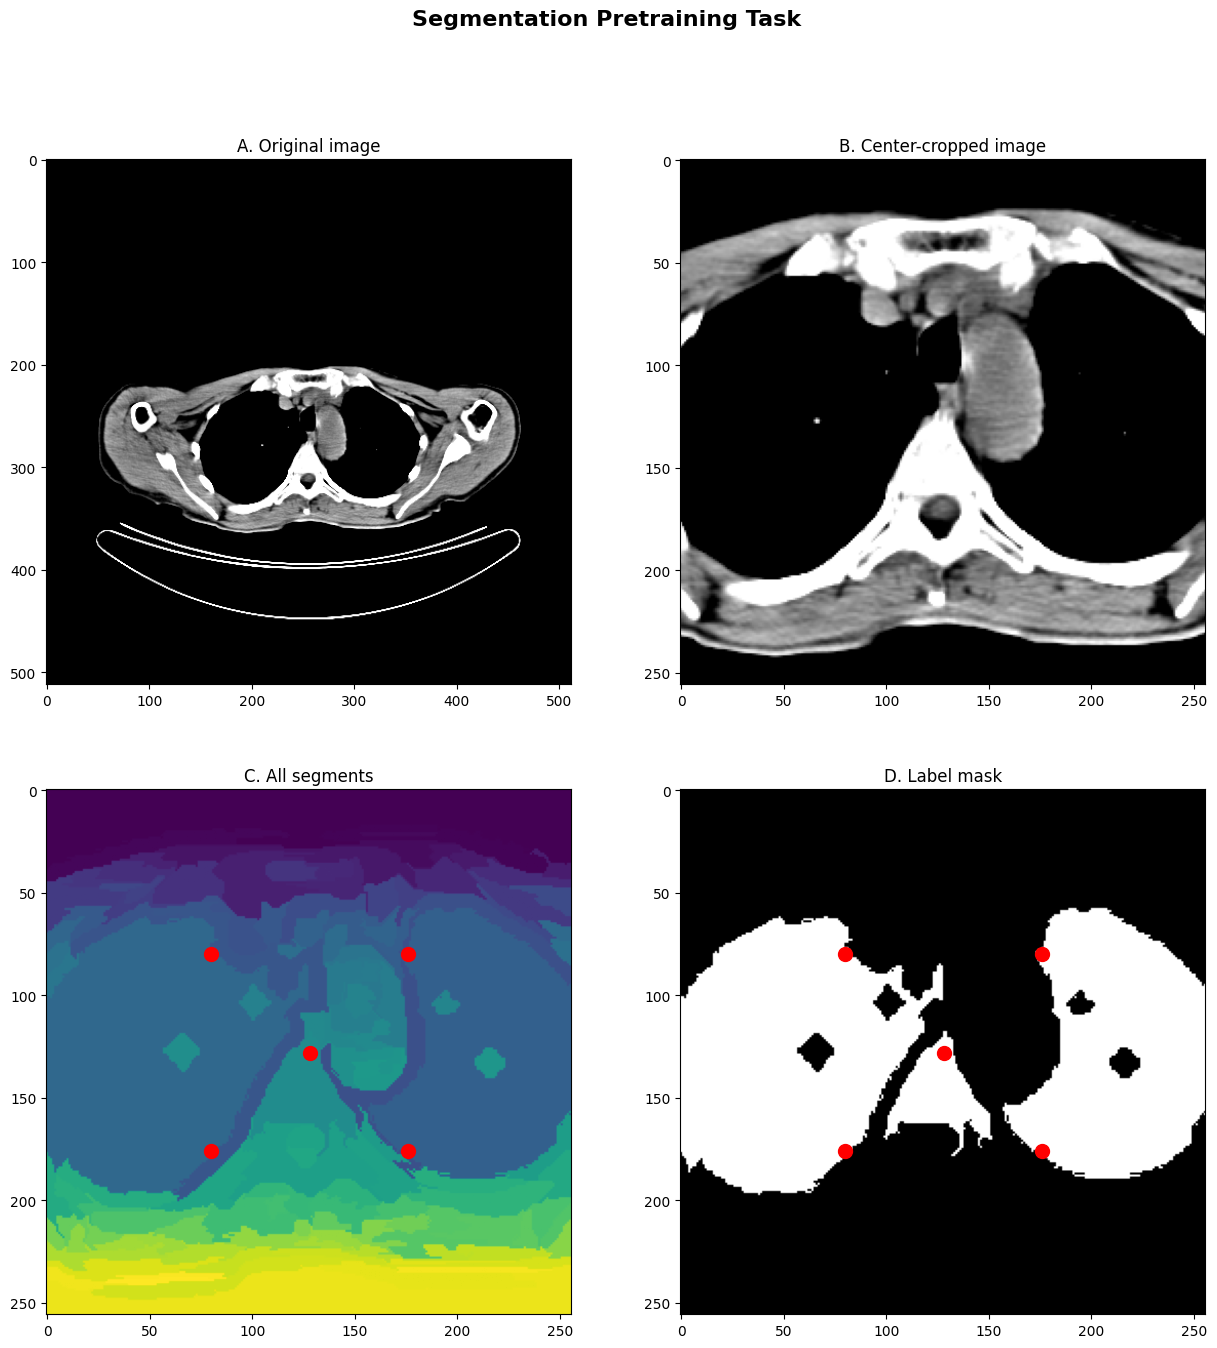

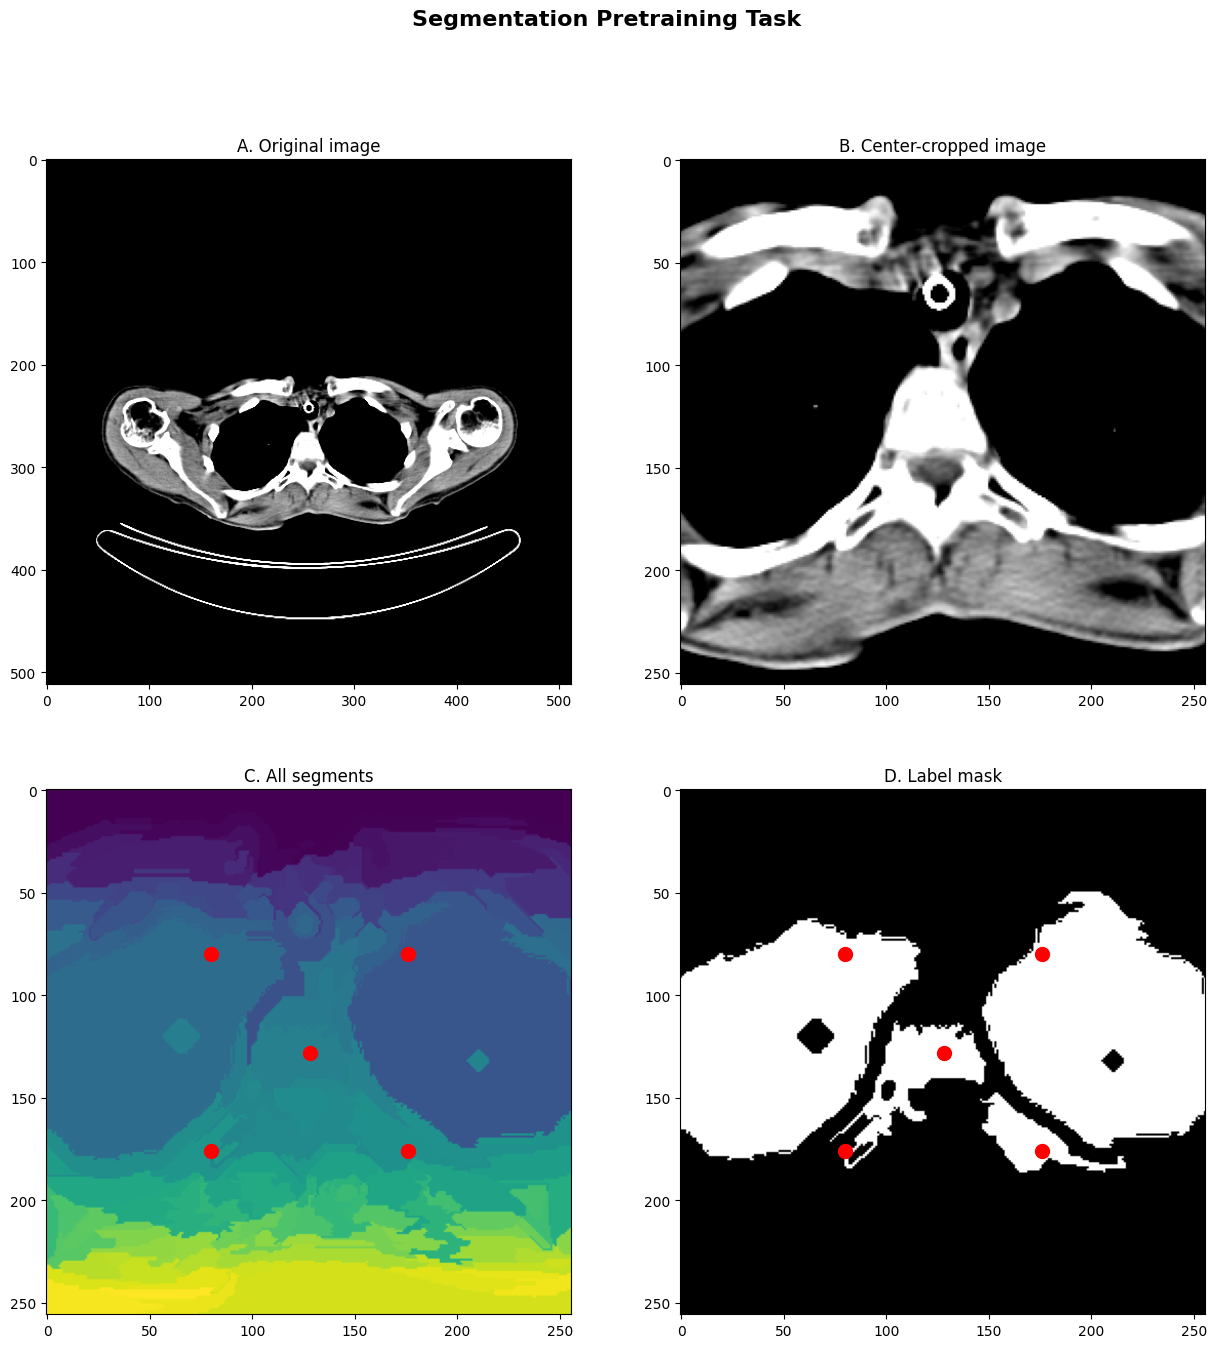

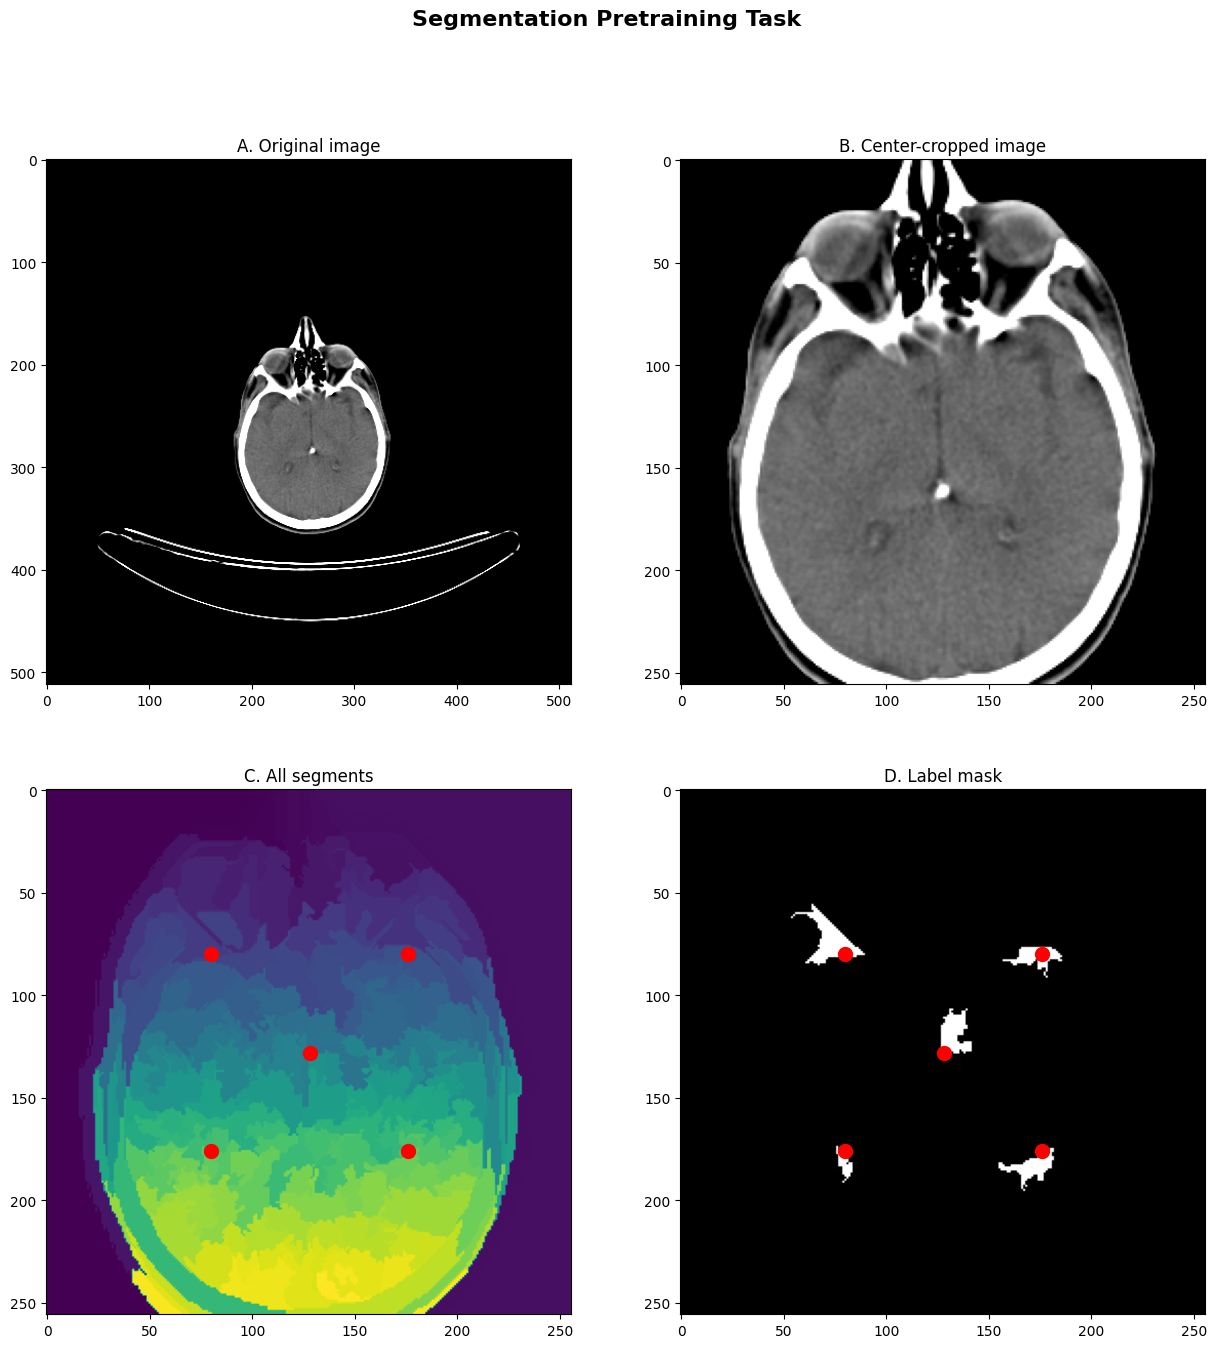

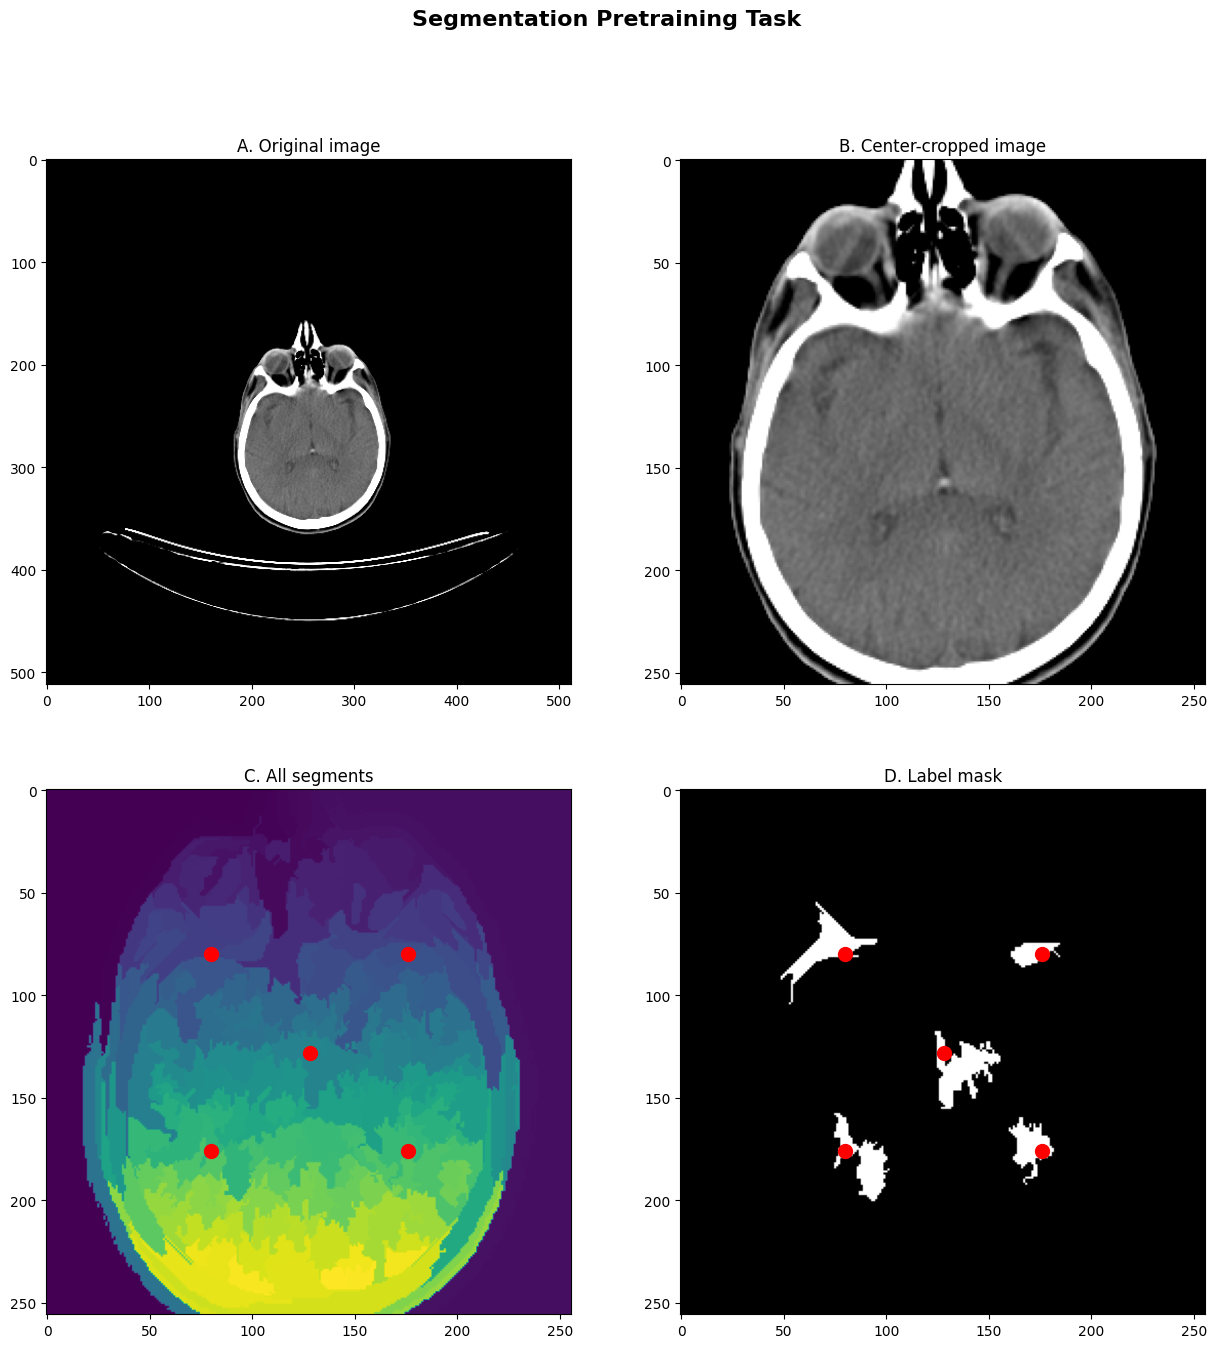

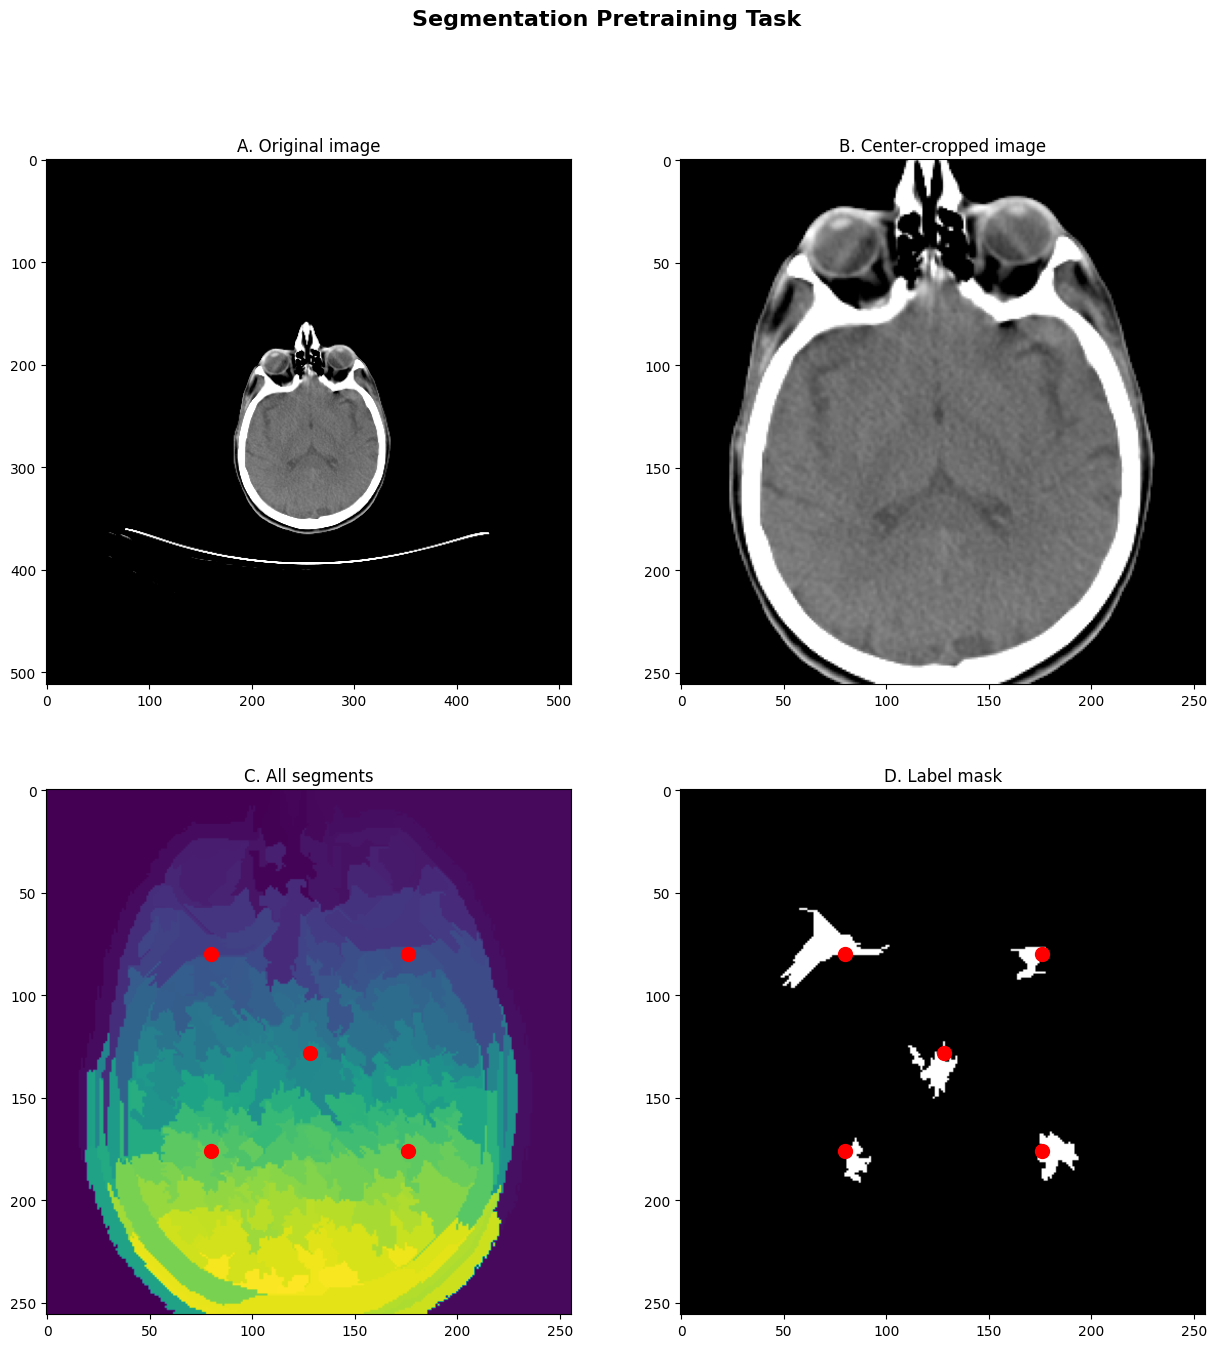

KeyboardInterrupt: 

In [21]:
pretrain_task = "felz"    # "jigsaw" or "felz"

if __name__ == '__main__':
    dl = create_dataloader(pretrain_task = pretrain_task)

    if pretrain_task == "felz":
        for (image, mask, img_path, slice_n, segments, metadata, super_pixels) in dl:
            raw_img = get_raw_image(img_path)

            plot_slices_and_mask(image, mask, raw_img, segments=segments, super_pixels = super_pixels)

    elif pretrain_task == "jigsaw":
        for (image, img_path, slice_n, tiles, coords, all_tiles, all_labels) in dl:
            plot_slice_and_tiles(image.type(torch.int16), all_tiles, coords)

        